- https://tech.kakao.com/2023/06/05/languagemodel-mlm-clm/

In [1]:
!pip install tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.6 MB/s eta 0:00:00


# [Load wikitext-2 Data](https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/)

In [2]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


# Tokenizer

특수 토큰(Special tokens)
- `<pad>`: token_id = 0
  - 서로 다른 길이의 문장을 처리하기 위해 짧은 문장을 긴 문장의 길이와 맞추기 위해 `<pad>`로 패딩합니다.
- `<unk>`: token_id = 1
  - 토크나이저가 모르는 단어를 만나면 unknown으로 처리하기 위한, 처리용 토큰입니다.
- `<s>`: token_id = 2
  - 문장의 시작을 알리는 토큰입니다. BOS(Begin of sentence), CLS(Classification) 토큰으로도 사용됩니다.
- `</s>`: token_id = 3
  - 문장의 끝을 알리는 토큰입니다. EOS(End of sentence), SEP(Seperator) 토큰으로도 사용됩니다.
- `<mask>`: token_id = 4
  - MLM 학습 시 쓰이는 토큰입니다. 토큰을 마스킹해서 이 토큰을 맞추는 문제를 풀 때 사용됩니다.

In [3]:
from tokenizers import CharBPETokenizer

tokenizer = CharBPETokenizer(suffix='', lowercase=True)

special_tokens = ['<pad>','<unk>','<s>','</s>','<mask>']
vocab_size = 36000
min_frequency = 2

tokenizer.train(files=DATA_PATH + 'wikitext-2/wiki.train.raw',
                vocab_size=vocab_size,
                min_frequency=min_frequency,
                special_tokens=special_tokens,
                suffix='')

tokenizer.save('tokenizer.json')

# Dataset Class

In [4]:
from torch.utils.data import Dataset
from tokenizers import Tokenizer

class MyDataset(Dataset):
    def __init__(self, text_path, tokenizer_path, seq_length):
        super().__init__()
        self.tokenizer = Tokenizer.from_file(tokenizer_path)
        self.pad_token = self.tokenizer.encode("<pad>").ids[0]
        self.unk_token = self.tokenizer.encode("<unk>").ids[0]
        self.bos_token = self.tokenizer.encode("<s>").ids[0]
        self.eos_token = self.tokenizer.encode("</s>").ids[0]
        self.mask_token = self.tokenizer.encode("<mask>").ids[0]
        self.input_ids = []
        buffer = []
        with open(text_path, "r") as f:
            for text in f.readlines():
                buffer.extend(self.tokenizer.encode(text).ids)

                # eos, bos 토큰을 붙이기 위해 seq_length-2 만큼 자른다.
                while len(buffer) >= seq_length - 2:
                    input_id = (
                        [self.bos_token] + buffer[: seq_length - 2] + [self.eos_token]
                    )
                    self.input_ids.append(input_id)
                    buffer = buffer[seq_length - 2 :]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx]

# Transformer

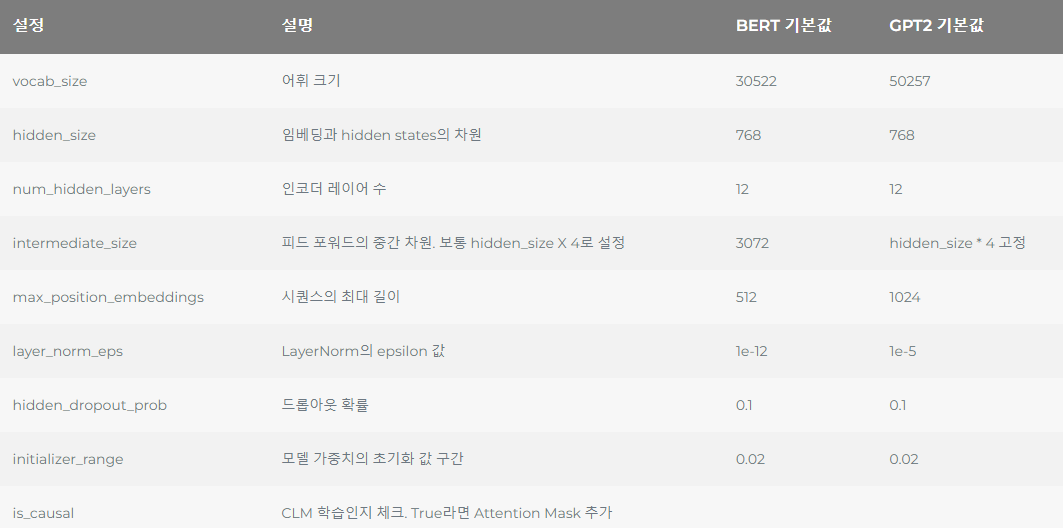

In [5]:
# model.py
class Config:
    def __init__(
        self,
        vocab_size=10000,
        hidden_size=512,
        num_hidden_layers=4,
        num_attention_heads=4,
        intermediate_size=2048,
        max_position_embeddings=128,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.1,
        initializer_range=0.02,
        is_causal=False,
    ):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.max_position_embeddings = max_position_embeddings
        self.layer_norm_eps = layer_norm_eps
        self.hidden_dropout_prob = hidden_dropout_prob
        self.initializer_range = initializer_range
        self.is_causal = is_causal

## Embedding & Positional Encoding

In [6]:
# model.py
import torch
from torch import nn

class Embedding(nn.Module):
    def __init__(self, config: Config):
        super().__init__()

        # Position Encoding
        self.position_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )
        # Embedding
        self.word_embeddings = nn.Embedding(
            config.vocab_size, config.hidden_size, padding_idx=0
        )
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids: torch.Tensor):
        seq_len = input_ids.size(1)
        position_ids = (
            torch.arange(seq_len, dtype=torch.long).unsqueeze(0).to(input_ids.device)
        )
        position_embeddings = self.position_embeddings(position_ids)
        word_embeddings = self.word_embeddings(input_ids)
        embeddings = word_embeddings + position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

## Transformer Encoder

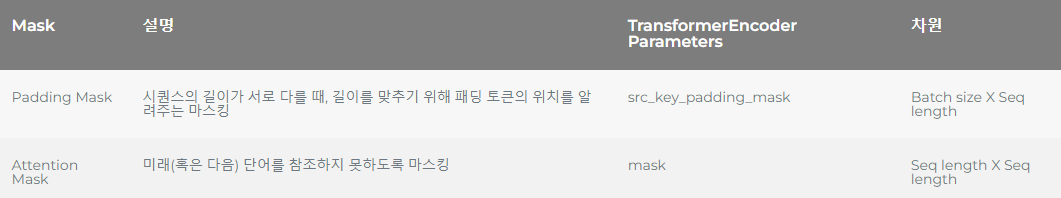

In [7]:
# model.py
import torch
from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        self.embeddings = Embedding(config)
        layers = nn.TransformerEncoderLayer(
            d_model=config.hidden_size,
            nhead=config.num_attention_heads,
            dim_feedforward=config.intermediate_size,
            dropout=config.hidden_dropout_prob,
            activation=F.gelu,
            layer_norm_eps=config.layer_norm_eps,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=layers, num_layers=config.num_hidden_layers
        )

    def forward(
        self,
        input_ids,
        attn_mask = None,
        padding_mask = None,
    ):
        if self.config.is_causal and attn_mask is None:
            size = input_ids.shape[1]
            device = input_ids.device
            attn_mask = torch.triu(
                torch.ones(size, size) * float("-inf"), diagonal=1
            ).to(device)

        x = self.embeddings(input_ids)
        x = self.encoder(x, mask=attn_mask, src_key_padding_mask=padding_mask)
        return x

# Masked Language Model
MLM(Masked Language Model)은 대표적인 모델은 BERT가 있고, 주로 텍스트 분류에서 강점을 보입니다.

## MLM 훈련 방법
1. 훈련 텍스트 시퀀스에서 일부 토큰을 임의로 선택하여 마스킹합니다. 이때 보통 15%의 토큰을 마스킹합니다.
2. 마스킹을 할 토큰의 80%는 `<mask>`라는 특수 토큰이 들어갑니다. 이 `<mask>` 토큰은 모델이 해당 위치에 있는 단어를 추론할 때 사용됩니다. 10%는 랜덤 토큰이 들어가고, 나머지 10%는 그대로 둡니다.
3. 마스킹된 문장을 모델에 입력하고, 마스킹된 위치에 있는 단어를 추론하도록 합니다.
4. 추론한 단어와 정답 단어 간의 오차를 계산하여 모델을 학습시킵니다.

이렇게 모델에게 마스킹된 토큰을 찾도록 훈련시키면, 모델이 토큰들 사이의 상관관계 및 문장의 문맥을 해석하는 능력을 기르게 할 수 있습니다.

## 코드

- MLM을 학습시키기 위해서는 위의 인코더 모델에 학습용 헤드를 붙여야 합니다.
  - 이 헤드는 Huggingface Transformers의 BERT 구현을 참고했습니다.
- 이 헤드에서는 인코더의 hidden states를 받아 vocab_size 길이를 가진 벡터를 결과로 냅니다.
- 이 결과와 마스킹된 위치의 원래 단어와 오차를 계산해 학습을 하게 됩니다.
- 또, 레이어의 가중치를 초기화하는 메서드를 구현해 모델 초기화를 할 수 있도록 합니다.

In [8]:
# model.py
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py#L704
class MLMHead(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.linear = nn.Linear(config.hidden_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.decoder = nn.Linear(config.hidden_size, config.vocab_size)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        self.decoder.bias = self.bias

    def forward(self, x):
        x = self.linear(x)
        x = self.gelu(x)
        x = self.layer_norm(x)
        x = self.decoder(x)
        return x


class MaskedLanguageModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        self.encoder: Encoder = Encoder(config)
        self.mlm_head = MLMHead(config)
        self.apply(self._init_weights)

        # https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py#L748
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_ids, padding_mask=None):
        x = self.encoder(input_ids, padding_mask=padding_mask)
        x = self.mlm_head(x)
        return x

다음은 토큰 시퀀스를 마스킹을 하고 레이블을 생성하기 위해 torch.utils.data.DataLoader의 collate_fn을 구현해 보겠습니다.

In [9]:
# dataset.py
from torch.nn.utils.rnn import pad_sequence

class MLMCollator:
    def __init__(self, tokenizer=None, special_token_cnt=5):
        self.tokenizer = tokenizer
        self.special_token_cnt = special_token_cnt

    def __call__(self, batch):
        input_ids = [torch.tensor(x) for x in batch]
        padding_mask = [get_padding_mask(x) for x in input_ids]
        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
        input_ids, labels = get_mask_tokens(
            input_ids, self.tokenizer, special_token_cnt=self.special_token_cnt
        )
        padding_mask = pad_sequence(padding_mask, batch_first=True, padding_value=True)
        return {
            "input_ids": input_ids,
            "labels": labels,
            "padding_mask": padding_mask,
        }


# https://github.com/huggingface/transformers/blob/main/src/transformers/data/data_collator.py#L748
def get_mask_tokens(input_ids, tokenizer, mlm_probability=0.15, special_token_cnt=5):
    input_ids = input_ids.clone()
    labels = input_ids.clone()

    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_token_mask = input_ids < special_token_cnt
    probability_matrix.masked_fill_(special_token_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100

    indices_replaced = (
        torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    )
    input_ids[indices_replaced] = tokenizer.encode("<mask>").ids[0]

    indices_random = (
        torch.bernoulli(torch.full(labels.shape, 0.5)).bool()
        & masked_indices
        & ~indices_replaced
    )

    random_words = torch.randint(
        tokenizer.get_vocab_size(), labels.shape, dtype=torch.long
    )
    input_ids[indices_random] = random_words[indices_random]

    return input_ids, labels


def get_padding_mask(input_id):
    return torch.zeros(input_id.shape).bool()

## 학습

In [12]:
# from dataset import MyDataset, MLMCollator
# from model import Config, MaskedLanguageModel
import torch
from torch.utils.data import DataLoader
from torch import nn

from tqdm.auto import tqdm

vocab_size = 36000
batch_size = 256
seq_length = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = MyDataset(DATA_PATH + 'wikitext-2/wiki.train.raw', "tokenizer.json", seq_length)
collate_fn = MLMCollator(train_dataset.tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn)

config = Config(
    vocab_size=vocab_size,
    hidden_size=256,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=1024,
    max_position_embeddings=seq_length,
)
model = MaskedLanguageModel(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()


def train(model: nn.Module, epoch):
    model.train()

    total_loss = 0.0
    total_iter = 0

    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        padding_mask = batch["padding_mask"].to(device)

        logits = model(input_ids, padding_mask=padding_mask)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iter += 1

    mean_loss = total_loss / total_iter
    print(f"epoch {epoch+1} : loss {mean_loss:1.4f}")
    return mean_loss

# 학습
train_loss_list = []
for epoch in tqdm(range(50)):
    mean_loss = train(model, epoch)
    train_loss_list.append(mean_loss)


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1 : loss 7.3607
epoch 2 : loss 6.8720
epoch 3 : loss 6.7229
epoch 4 : loss 6.6061
epoch 5 : loss 6.5083
epoch 6 : loss 6.4392
epoch 7 : loss 6.3841
epoch 8 : loss 6.3351
epoch 9 : loss 6.2940
epoch 10 : loss 6.2479
epoch 11 : loss 6.1961
epoch 12 : loss 6.1725
epoch 13 : loss 6.1427
epoch 14 : loss 6.1145
epoch 15 : loss 6.0369
epoch 16 : loss 5.9689
epoch 17 : loss 5.8440
epoch 18 : loss 5.6648
epoch 19 : loss 5.3703
epoch 20 : loss 5.1133
epoch 21 : loss 4.9230
epoch 22 : loss 4.7770
epoch 23 : loss 4.6613
epoch 24 : loss 4.5509
epoch 25 : loss 4.4719
epoch 26 : loss 4.3923
epoch 27 : loss 4.3047
epoch 28 : loss 4.2519
epoch 29 : loss 4.1783
epoch 30 : loss 4.1152
epoch 31 : loss 4.0705
epoch 32 : loss 4.0222
epoch 33 : loss 3.9785
epoch 34 : loss 3.9236
epoch 35 : loss 3.8983
epoch 36 : loss 3.8480
epoch 37 : loss 3.8099
epoch 38 : loss 3.7744
epoch 39 : loss 3.7268
epoch 40 : loss 3.6975
epoch 41 : loss 3.6685
epoch 42 : loss 3.6390
epoch 43 : loss 3.6030
epoch 44 : loss 3.57

<Axes: >

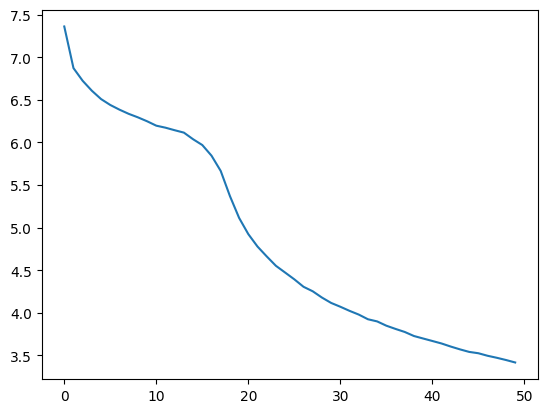

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(train_loss_list)

# Causal Language Model
- Causal Language Model(CLM)은 시퀀스에서 이전 토큰들을 기반으로 다음 토큰을 찾는 작업을 수행합니다.
  - 이렇게 인과적인 관계를 찾기 때문에 Causal이라 불립니다.
- 이 방법은 다음에 나올 토큰은 이전 토큰들에만 영향을 받는다고 가정하고 동작합니다.
  - 이전 토큰들이 주어졌을 때 다음에 나올 토큰 중 가장 높은 확률을 선택하기 때문에 CLM으로 생성한 텍스트는 자연스럽다는 장점이 있습니다.
- 대표적인 모델은 GPT가 있습니다.

## 코드

- MLM과 같이 CLM도 인코더에 붙일 헤드를 먼저 만들어야 합니다.
- BERT와 다르게 GPT2의 헤드는 간단하게 완전 연결층 하나로 되어 있습니다.
- 그리고 여기에서도 MLM처럼 모델을 초기화하는 함수를 적용해 줍니다.

In [14]:
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py#L958
class CausalLanguageModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        self.encoder: Encoder = Encoder(config)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.clm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        self.apply(self._init_weights)

    # https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py#L457
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_ids, attn_mask=None, padding_mask=None):
        x = self.encoder(input_ids, attn_mask=attn_mask, padding_mask=padding_mask)
        x = self.layer_norm(x)
        x = self.clm_head(x)
        return x

- CLM의 collate_fn 함수는 MLM보다 간단합니다.
- 마스킹 없이 현재 토큰 시퀀스를 한 칸 앞으로 당겨서 레이블을 만들기만 하면 됩니다.
- torch.roll()을 사용해 텐서를 한 칸 앞으로 당기고 마지막 토큰(`</s>`)의 다음 예측을 막기 위해 -100으로 설정합니다.

In [15]:
class CLMCollator:
    def __init__(self, tokenizer=None):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        input_ids = [torch.tensor(x) for x in batch]
        padding_mask = [get_padding_mask(x) for x in input_ids]

        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
        labels = input_ids.clone()
        labels = torch.roll(labels, -1, -1)
        labels[:-1] = -100
        padding_mask = pad_sequence(padding_mask, batch_first=True, padding_value=True)
        return {"input_ids": input_ids, "labels": labels, "padding_mask": padding_mask}

## 학습

In [16]:
# from dataset import MyDataset, MLMCollator
# from model import Config, MaskedLanguageModel
import torch
from torch.utils.data import DataLoader
from torch import nn

from tqdm.auto import tqdm

vocab_size = 36000
batch_size = 256
seq_length = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = MyDataset(DATA_PATH + 'wikitext-2/wiki.train.raw', "tokenizer.json", seq_length)
collate_fn = CLMCollator(train_dataset.tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn)

config = Config(
    vocab_size=vocab_size,
    hidden_size=256,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=1024,
    max_position_embeddings=seq_length,
)
model = CausalLanguageModel(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()


def train(model: nn.Module, epoch):
    model.train()

    total_loss = 0.0
    total_iter = 0

    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        padding_mask = batch["padding_mask"].to(device)

        logits = model(input_ids, padding_mask=padding_mask)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iter += 1

    mean_loss = total_loss / total_iter
    print(f"epoch {epoch+1} : loss {mean_loss:1.4f}")
    return mean_loss

# 학습
train_loss_list = []
for epoch in tqdm(range(50)):
    mean_loss = train(model, epoch)
    train_loss_list.append(mean_loss)


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1 : loss 7.6243
epoch 2 : loss 5.9801
epoch 3 : loss 5.0532
epoch 4 : loss 4.2149
epoch 5 : loss 3.4890
epoch 6 : loss 2.8517
epoch 7 : loss 2.1923
epoch 8 : loss 1.2269
epoch 9 : loss 0.5671
epoch 10 : loss 0.2266
epoch 11 : loss 0.0969
epoch 12 : loss 0.0500
epoch 13 : loss 0.0310
epoch 14 : loss 0.0228
epoch 15 : loss 0.0159
epoch 16 : loss 0.0147
epoch 17 : loss 0.0108
epoch 18 : loss 0.0084
epoch 19 : loss 0.0076
epoch 20 : loss 0.0100
epoch 21 : loss 0.0083
epoch 22 : loss 0.0138
epoch 23 : loss 0.0203
epoch 24 : loss 0.0198
epoch 25 : loss 0.0211
epoch 26 : loss 0.0114
epoch 27 : loss 0.0108
epoch 28 : loss 0.0080
epoch 29 : loss 0.0097
epoch 30 : loss 0.0103
epoch 31 : loss 0.0067
epoch 32 : loss 0.0117
epoch 33 : loss 0.0146
epoch 34 : loss 0.0127
epoch 35 : loss 0.0067
epoch 36 : loss 0.0093
epoch 37 : loss 0.0087
epoch 38 : loss 0.0091
epoch 39 : loss 0.0078
epoch 40 : loss 0.0075
epoch 41 : loss 0.0082
epoch 42 : loss 0.0078
epoch 43 : loss 0.0084
epoch 44 : loss 0.00

<Axes: >

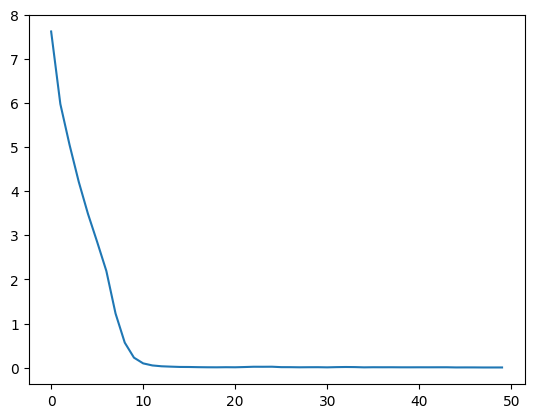

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(train_loss_list)